In [1]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
import pandas as pd

In [2]:
# Create the linspace dataframe between max and min value of each parameter
def data_linspace(material_name):
    df = pd.read_csv('norm_file/norm_%s.csv' %(material_name))
    df = df.drop(['OD'], axis=1)
    para = ['norm_con','norm_vol','norm_dis','norm_feed']
    lin = [[],[],[],[]]
    count = 0
    for i in para:
        dd = np.linspace(df[i].min(),df[i].max(),100)
        lin[count] = dd
        count+=1
    d = {para[0] : lin[0], para[1] : lin[1], para[2] : lin[2], para[3] : lin[3]}
    lin = pd.DataFrame(data = d)
    return lin

# Create the constant number of each input parameter
def constant_table_2D(con,vol,dis,feed):
    con = [con] * 100
    vol = [vol] * 100
    dis = [dis] * 100
    feed = [feed] * 100
    d = {'norm_con':con, 'norm_vol':vol,'norm_dis':dis,'norm_feed':feed}
    df = pd.DataFrame(data = d)
    return df

# Create the tabel which using for predicted by the ANN model
# The table vary only one parameter for predict and plot 2D graph
def predicted_table_2D(para,lin,table):
    df = table
    df[para] = lin[para]
    return df

# Create the predicted table for Mixing ANN model
# Because Mixing model must add one more feature which is the type of material
def mix_tabel(name, df):
    mix = pd.read_csv('original/Mixing.csv')
    material = pd.read_csv('original/%s.csv' %name)
    para = ['con','vol','dis','feed']
    mix_list = [[],[],[],[]]
    count = 0
    for i in para:
        pmax = material[i].max()
        pmin = material[i].min()
        mmax = mix[i].max()
        mmin = mix[i].min()
        
        mix_list[count] = df['norm_%s' %i]*(pmax-pmin)/(mmax-mmin)
        count += 1
    
    if name == 'Kefiran':
        num_mat = 1
    elif name == 'Nylon':
        num_mat = 2
    elif name == 'PU':
        num_mat = 3
    elif name == 'PMMA':
        num_mat = 4
        
    num_mat = [num_mat]*100
    d = {'norm_con':mix_list[0], 'norm_vol':mix_list[1],'norm_dis':mix_list[2],'norm_feed':mix_list[3]}
    mix_list = pd.DataFrame(data = d)
    mix_list.insert(loc=0, column='material', value=num_mat)
    return mix_list

# Varying the x-axis for the 3D surface plot
def x_3D(name):
    lin = data_linspace(name)
    para = ['norm_con','norm_vol','norm_dis','norm_feed']
    x = [[],[],[],[]]
    count = 0
    for i in para:
        dd = lin[i].tolist()
        dd = dd*100
        x[count] = dd
        count+=1
    d = {para[0] : x[0], para[1] : x[1], para[2] : x[2], para[3] : x[3]}
    lin = pd.DataFrame(data = d)
    return lin

# Varying the y-axis for the 3D surface plot
def y_3D(name):
    lin = data_linspace(name)
    para = ['norm_con','norm_vol','norm_dis','norm_feed']
    y = [[],[],[],[]]
    count = 0
    for i in para:
        dd = lin[i].tolist()
        dd = dd*100
        dd = np.array(dd)
        dd = np.reshape(dd, (100,100))
        dd = np.transpose(dd)
        dd = np.reshape(dd, (10000))
        y[count] = dd
        count+=1
    d = {para[0] : y[0], para[1] : y[1], para[2] : y[2], para[3] : y[3]}
    lin = pd.DataFrame(data = d)
    return lin

# Create the constant number of each input parameter for 3D prediction
def constant_table_3D(con,vol,dis,feed):
    con = [con] * 10000
    vol = [vol] * 10000
    dis = [dis] * 10000
    feed = [feed] *10000
    d = {'norm_con':con, 'norm_vol':vol,'norm_dis':dis,'norm_feed':feed}
    lin = pd.DataFrame(data = d)
    return lin

# Create the tabel which using for predicted by the ANN model
# The table vary only one parameter for predict and plot 2D graph
def predicted_table_3D(parax,paray,linx,liny,table):
    df = table
    df[parax] = linx[parax]
    df[paray] = liny[paray]
    return df


# Import the model and use that model to predict the table that input in this function
# Output is the table of normalize diameter
def prediction(material,model,df):
    model_address = 'model_%s/%s_relu_%s.h5' %(material, material, model)
    model = load_model(model_address)
    y_predict = model.predict(df)
    y_pred = []
    for i in range(0,len(y_predict)):
        y_pred.append(y_predict[i][0])
    d = {'y_pred' : y_pred}
    y_pred = pd.DataFrame(data = d)
    return y_pred

# Input the normalize parameters and diameters and reverse normalize to the real value
# Using for real 2D plotting
def data_for_plot_2D(name,df,y_pred):
    real = pd.read_csv('original/%s.csv' %(name))
    para = ['con','vol','dis','feed']
    plott = [[],[],[],[]]
    count = 0
    for i in para:
        pmax = real[i].max()
        pmin = real[i].min()
        plott[count] = df['norm_%s' %i]*(pmax-pmin)
        count += 1
    d = {'norm_con':plott[0], 'norm_vol':plott[1],'norm_dis':plott[2],'norm_feed':plott[3]}
    plott = pd.DataFrame(data = d)
    y_plott = y_pred * (real['OD'].max() - real['OD'].min())
    plott['Y'] = y_plott['y_pred']
    return plott

# Input the normalize parameters and diameters and reverse normalize to the real value
# Output is the data of 3D surface plot by using matplotlib plot_surface
def data_for_plot_3D(x,y,df):    
    X = df[x]
    Y = df[y].to_list()
    Z = df['Y']
    XX = X[:100].to_list()
    XX = np.array(XX)
    yy = np.array(Y)
    yy = np.reshape(yy, (100,100))
    YY = []
    for i in range(0,100):
        YY.append(yy[i][0])
    YY = np.array(YY)    
    ZZ = np.array(Z)
    ZZ = np.reshape(ZZ, (100,100))
    XX, YY = np.meshgrid(XX, YY, sparse=True)
    return XX, YY, ZZ

In [3]:
# Example for the surface plot
name = 'Kefiran'
model = '20_29_4'
namex = 'norm_vol'
namey = 'norm_feed'
linx = x_3D(name)
liny = y_3D(name)

table = constant_table_3D(1.5,1,2.333333333,2.833333333)
df = predicted_table_3D(namex,namey,linx,liny,table)
y_pred = prediction(name,model,df)
plott = data_for_plot_2D(name,df,y_pred)
XX1,YY1,ZZ1 = data_for_plot_3D(namex,namey,plott) 

table = constant_table_3D(1.5,1,3.333333333,3.833333333)
df = predicted_table_3D(namex,namey,linx,liny,table)
y_pred = prediction(name,model,df)
plott = data_for_plot_2D(name,df,y_pred)
XX2,YY2,ZZ2 = data_for_plot_3D(namex,namey,plott)  

table = constant_table_3D(2.5,2,2.333333333,2.833333333)
df = predicted_table_3D(namex,namey,linx,liny,table)
y_pred = prediction(name,model,df)
plott = data_for_plot_2D(name,df,y_pred)
XX3,YY3,ZZ3 = data_for_plot_3D(namex,namey,plott) 

table = constant_table_3D(2.5,2,3.333333333,3.833333333)
df = predicted_table_3D(namex,namey,linx,liny,table)
y_pred = prediction(name,model,df)
plott = data_for_plot_2D(name,df,y_pred)
XX4,YY4,ZZ4 = data_for_plot_3D(namex,namey,plott)  

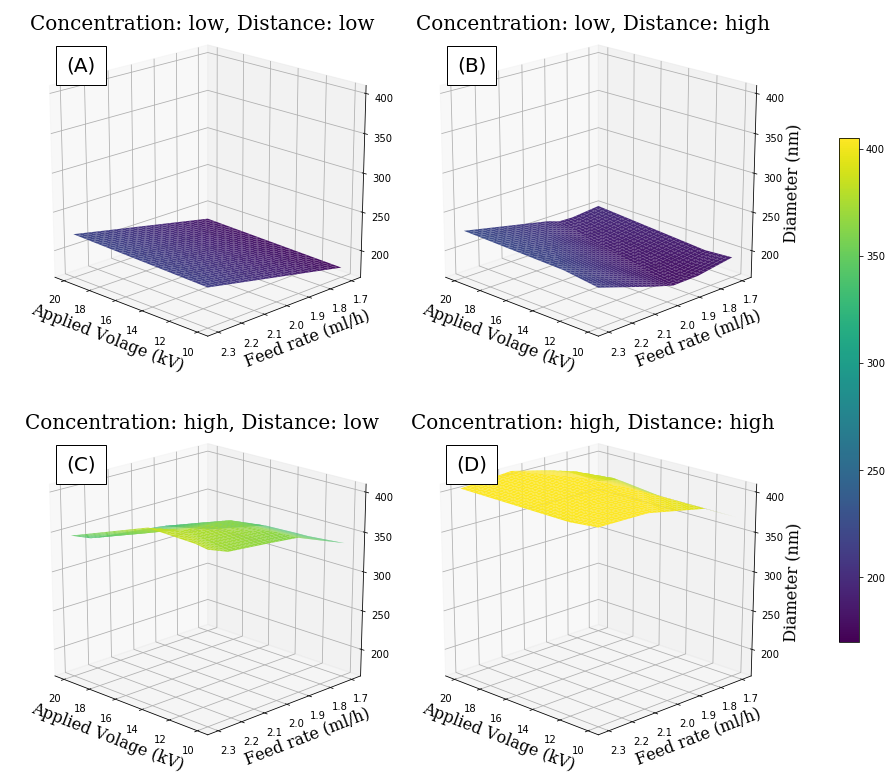

In [4]:
a = 16 # fontsize
fig = plt.figure(figsize=(14,14))
dis = 'Applied Volage (kV)'
feed = 'Feed rate (ml/h)'
maxx = 405
minn = 170

ax1 = fig.add_subplot(2, 2, 1, projection='3d')
surf = ax1.plot_surface(XX1, YY1, ZZ1, rstride=3, cstride=3, cmap='viridis', vmin = minn, vmax=  maxx)
ax1.view_init(elev = 20,azim = 135)
ax1.set_xlabel(dis,fontsize = a, fontfamily = 'serif')
ax1.set_ylabel(feed,fontsize = a, fontfamily = 'serif')
ax1.set_zlim(minn,maxx)
ax1.text2D(-0.06, 0.06, '(A)', size=20, ha='center', va='center',bbox ={'facecolor':'white', 'pad':10})

ax2 = fig.add_subplot(2, 2, 2, projection='3d')
surf = ax2.plot_surface(XX2, YY2, ZZ2, rstride=3, cstride=3, cmap='viridis', vmin = minn, vmax=  maxx)
ax2.view_init(elev = 20,azim = 135)
ax2.set_xlabel(dis,fontsize = a, fontfamily = 'serif')
ax2.set_ylabel(feed,fontsize = a, fontfamily = 'serif')
ax2.set_zlabel('Diameter (nm)',fontsize = a, fontfamily = 'serif')
ax2.set_zlim(minn,maxx)
ax2.text2D(-0.06, 0.06, '(B)', size=20, ha='center', va='center',bbox ={'facecolor':'white', 'pad':10})

ax3 = fig.add_subplot(2, 2, 3, projection='3d')
surf = ax3.plot_surface(XX3, YY3, ZZ3, rstride=3, cstride=3, cmap='viridis', vmin = minn, vmax=  maxx)
ax3.view_init(elev = 20,azim = 135)
ax3.set_xlabel(dis,fontsize = a, fontfamily = 'serif')
ax3.set_ylabel(feed,fontsize = a, fontfamily = 'serif')
ax3.set_zlim(minn,maxx)
ax3.text2D(-0.06, 0.06, '(C)', size=20, ha='center', va='center',bbox ={'facecolor':'white', 'pad':10})

ax4 = fig.add_subplot(2, 2, 4, projection='3d')
surf = ax4.plot_surface(XX4, YY4, ZZ4, rstride=3, cstride=3, cmap='viridis', vmin = minn, vmax=  maxx)
ax4.view_init(elev = 20,azim = 135)
ax4.set_xlabel(dis,fontsize = a, fontfamily = 'serif')
ax4.set_ylabel(feed,fontsize = a, fontfamily = 'serif')
ax4.set_zlabel('Diameter (nm)',fontsize = a, fontfamily = 'serif')
ax4.set_zlim(minn,maxx)
ax4.text2D(-0.06, 0.06, '(D)', size=20, ha='center', va='center',bbox ={'facecolor':'white', 'pad':10})
fig.subplots_adjust(wspace = 0,hspace=0.1)
cbar_ax = fig.add_axes([0.95, 0.25, 0.02, 0.5])
fig.colorbar(surf, cax=cbar_ax)

ax1.set_title('Concentration: low, Distance: low', fontsize = 20, fontfamily = 'serif')
ax2.set_title('Concentration: low, Distance: high', fontsize = 20, fontfamily = 'serif')
ax3.set_title('Concentration: high, Distance: low', fontsize = 20, fontfamily = 'serif')
ax4.set_title('Concentration: high, Distance: high', fontsize = 20, fontfamily = 'serif')

plt.show()

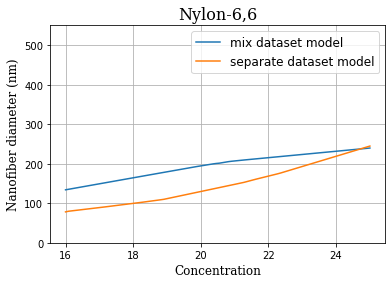

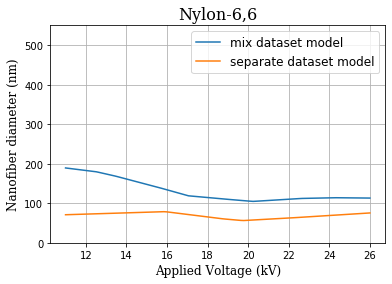

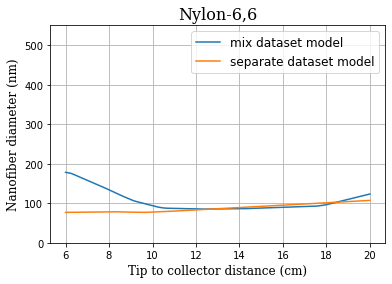

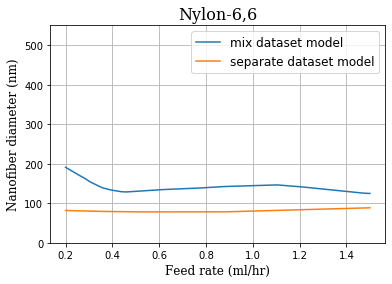

In [5]:
# Example for the 2D plot
name = 'Nylon'
model = '9_29_19'
polymer = ['Kefiran', 'PMMA', 'Nylon-6,6', 'PU']
para = ['con', 'vol', 'dis', 'feed']
labell = ['Concentration', 'Applied Voltage (kV)', 'Tip to collector distance (cm)', 'Feed rate (ml/hr)']

for i in range(0,4):
    lin = data_linspace(name)
    table = constant_table_2D(1.777777778,1.066666667,0.571428571,0.461538462)
    df = predicted_table_2D('norm_%s'%para[i],lin,table)
    y_pred = prediction(name,model,df)
    plott = data_for_plot_2D(name,df,y_pred)
    
    mix = mix_tabel(name, df)
    y_mix_pred = prediction('Mixing','13_30_21',mix)
    mixplott = data_for_plot_2D('Mixing',mix,y_mix_pred)
    
    plt.plot(mixplott['norm_%s'%para[i]],mixplott['Y'],label = 'mix dataset model')
    plt.plot(plott['norm_%s'%para[i]],plott['Y'], label = 'separate dataset model')
    plt.title(polymer[2], fontsize = 16, fontfamily = 'serif')
    plt.grid()
    plt.ylim(0, 550)
    plt.ylabel('Nanofiber diameter (nm)', fontsize = 12, fontfamily = 'serif')
    plt.xlabel(labell[i], fontsize = 12, fontfamily = 'serif')
    plt.legend(fontsize = 12)
    plt.show()